<a href="https://colab.research.google.com/github/moabe84/solvation_free_energy/blob/main/MLModelsTrianing_DeepChem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the DeepChem package
!pip install --pre deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 KB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 46.3 MB/s eta 0:00:00


In [ ]:
# Import libraries
from rdkit import Chem
from rdkit.Chem import Descriptors

import deepchem as dc
import torch
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Let's see how our data looks like
path = 'solv_free_energy_dataset_HCNO.csv'
data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963 entries, 0 to 1962
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   smiles         1963 non-null   object 
 1   cal_solv_free  1963 non-null   float64
dtypes: float64(1), object(1)
memory usage: 30.8+ KB


Standard Deviation from Mean = 3.5371988457468704


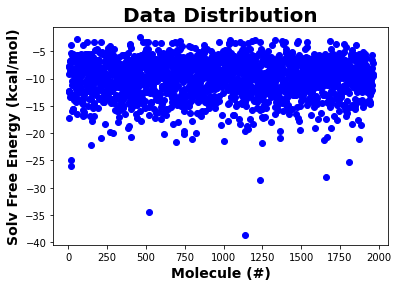

In [4]:
# Let's plot the calculated solvation free energy data
plt.scatter(x = np.arange(1, len(data['cal_solv_free'])+1), y = data['cal_solv_free'], c = 'blue')
plt.title('Data Distribution', fontsize = 20, weight = 'bold')
plt.xlabel('Molecule (#)', fontsize = 14, weight = 'bold')
plt.ylabel('Solv Free Energy (kcal/mol)', fontsize = 14, weight = 'bold')

# Calculate standard deviation from mean
print('Standard Deviation from Mean =', np.std(data['cal_solv_free']))

Standard Deviation from Mean = 2.7009349311086686


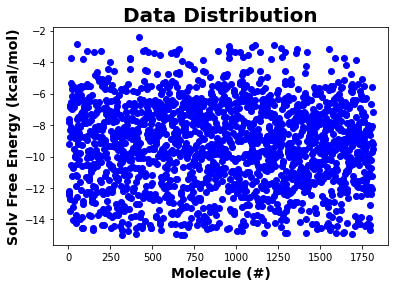

In [5]:
# Clean up the data by removing the data points with energy below -15 kcal/mol
for i, row in data.iterrows():
    if row['cal_solv_free'] <= -15.00:
        data.drop(i, inplace = True)

plt.scatter(x = np.arange(1,len(data['cal_solv_free'])+1), y=data['cal_solv_free'], c = 'blue')
plt.title('Data Distribution', fontsize = 20, weight = 'bold')
plt.xlabel('Molecule (#)', fontsize = 14, weight = 'bold')
plt.ylabel('Solv Free Energy (kcal/mol)', fontsize = 14, weight = 'bold')

# Calculate standard deviation from mean
print('Standard Deviation from Mean =', np.std(data['cal_solv_free']))

## **Directed Message Passing Neural Network Model**

Train scores = {'mean-pearson_r2_score': 0.993911051410311}
Test scores = {'mean-pearson_r2_score': 0.8509096437811593}
Validation scores = {'mean-pearson_r2_score': 0.8620345726276097}


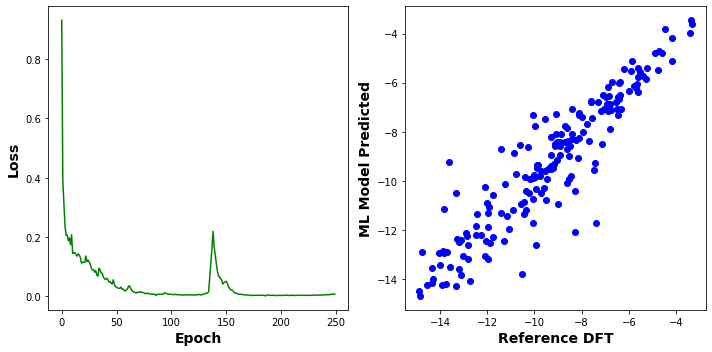

In [7]:
import warnings
warnings.filterwarnings('ignore')

# 1) Convert SMILES to graphs using Weave convolutions
featurizer = dc.feat.WeaveFeaturizer()
features = featurizer.featurize(data['smiles'])

# 2) Build the dataset
dataset = dc.data.NumpyDataset(X = features, y = data['cal_solv_free'])

# 3) Split the dataset into the training, validation, and test sets
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# 4) Normalize the dataset
transformer = dc.trans.NormalizationTransformer(transform_y = True, dataset = dataset)
train_dataset = transformer.transform(train_dataset)
valid_dataset = transformer.transform(valid_dataset)
test_dataset = transformer.transform(test_dataset)

# 5) Set the metrics
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)

# 6) Trian the model
model = dc.models.MPNNModel(n_tasks = 1, n_atom_feat = 75, n_pair_feat = 14, batch_size = 64, learning_rate = 0.001, mode = "regression")

losses = []
for i in range(250):
  loss = model.fit(train_dataset, nb_epoch = 1)
#  print(f'Epoch {i}  Loss = {loss:.2f}')
  losses.append(loss)

# 7) Compute and print the scores
train_scores = model.evaluate(train_dataset, [metric])
test_scores = model.evaluate(test_dataset, [metric])
valid_scores = model.evaluate(valid_dataset, [metric])
                              
print(f'Train scores = {train_scores}')
print(f'Test scores = {test_scores}')
print(f'Validation scores = {valid_scores}')

# 8) Plot the losses
plt.subplots(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, 'green')
plt.xlabel('Epoch', fontsize = 14, weight = 'bold')
plt.ylabel('Loss', fontsize = 14, weight = 'bold')

# 9) Prediction
test_preds = model.predict(test_dataset)
test_preds = transformer.untransform(test_preds)
test_dataset = transformer.untransform(test_dataset.y)

plt.subplot(1, 2, 2)
plt.scatter(x = test_dataset, y = test_preds, c = 'blue')
plt.xlabel('Reference DFT', fontsize = 14, weight = 'bold')
plt.ylabel('ML Model Predicted', fontsize = 14, weight = 'bold')

plt.tight_layout()
plt.show()

## **Graph Convolutional Model**

Train scores = {'mean-pearson_r2_score': 0.9932712753619756}
Test scores = {'mean-pearson_r2_score': 0.8127458084003111}
Validation scores = {'mean-pearson_r2_score': 0.8389148381202166}


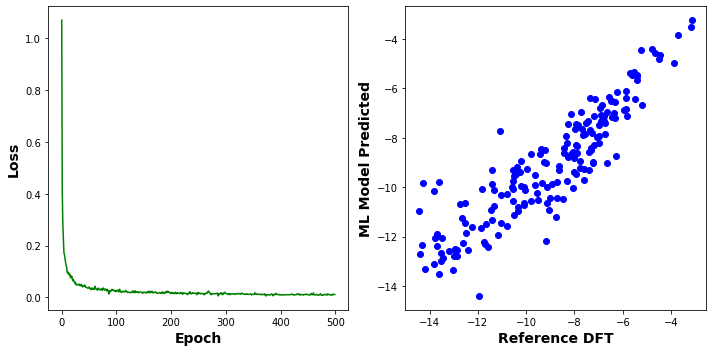

In [8]:
# 1) Convert SMILES to graphs using Duvenaud graph convolutions
featurizer = dc.feat.ConvMolFeaturizer()
features = featurizer.featurize(data['smiles'])

# 2) Build the dataset
dataset = dc.data.NumpyDataset(X = features, y = data['cal_solv_free'])

# 3) Split the dataset into the training, validation, and test sets
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# 4) Normalize the dataset
transformer = dc.trans.NormalizationTransformer(transform_y = True, dataset = dataset)
train_dataset = transformer.transform(train_dataset)
valid_dataset = transformer.transform(valid_dataset)
test_dataset = transformer.transform(test_dataset)

# 5) Set the metrics
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)

# 6) Trian the model
model = dc.models.GraphConvModel(n_tasks = 1, batch_size = 64, learning_rate = 0.001, mode = 'regression')

losses = []
for i in range(500):
  loss = model.fit(train_dataset, nb_epoch = 1)
#  print(f'Epoch {i}  Loss = {loss:.2f}')
  losses.append(loss)

# 7) Compute and print the scores
train_scores = model.evaluate(train_dataset, [metric])
test_scores = model.evaluate(test_dataset, [metric])
valid_scores = model.evaluate(valid_dataset, [metric])
                              
print(f'Train scores = {train_scores}')
print(f'Test scores = {test_scores}')
print(f'Validation scores = {valid_scores}')

# 8) Plot the losses
plt.subplots(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, 'green')
plt.xlabel('Epoch', fontsize = 14, weight = 'bold')
plt.ylabel('Loss', fontsize = 14, weight = 'bold')

# 9) Prediction
test_preds = model.predict(test_dataset)
test_preds = transformer.untransform(test_preds)
test_dataset = transformer.untransform(test_dataset.y)

plt.subplot(1, 2, 2)
plt.scatter(x = test_dataset, y = test_preds, c = 'blue')
plt.xlabel('Reference DFT', fontsize = 14, weight = 'bold')
plt.ylabel('ML Model Predicted', fontsize = 14, weight = 'bold')

plt.tight_layout()
plt.show()

## **Multitask Regression Model**

Train scores = {'mean-pearson_r2_score': 0.9940597307539503}
Test scores = {'mean-pearson_r2_score': 0.7711116059607216}
Validation scores = {'mean-pearson_r2_score': 0.7082685729506627}


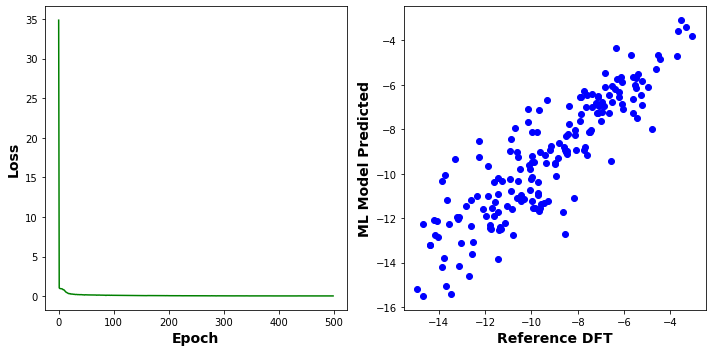

In [9]:
# 1) Convert SMILES to graphs using Circular (Morgan) fingerprints
featurizer = dc.feat.CircularFingerprint(size=1024)
features = featurizer.featurize(data['smiles'])

# 2) Build the dataset
dataset = dc.data.NumpyDataset(X = features, y = data['cal_solv_free'])

# 3) Split the dataset into the training, validation, and test sets
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# 4) Normalize dataset
transformer = dc.trans.NormalizationTransformer(transform_y = True, dataset = dataset)
train_dataset = transformer.transform(train_dataset)
valid_dataset = transformer.transform(valid_dataset)
test_dataset = transformer.transform(test_dataset)

# 5) Set the metrics
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)

# 6) Trian the model
model = dc.models.MultitaskRegressor(n_tasks = 1, n_features = 1024, batch_size = 64, layer_sizes = [2000, 1000], learning_rate = 0.001, mode = 'regression')

losses = []
for i in range(500):
  loss = model.fit(train_dataset, nb_epoch = 1)
#  print(f'Epoch {i}  Loss = {loss:.2f}')
  losses.append(loss)

# 7) Compute and print the scores
train_scores = model.evaluate(train_dataset, [metric])
test_scores = model.evaluate(test_dataset, [metric])
valid_scores = model.evaluate(valid_dataset, [metric])
                              
print(f'Train scores = {train_scores}')
print(f'Test scores = {test_scores}')
print(f'Validation scores = {valid_scores}')

# 8) Plot the losses
plt.subplots(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, 'green')
plt.xlabel('Epoch', fontsize = 14, weight = 'bold')
plt.ylabel('Loss', fontsize = 14, weight = 'bold')

# 9) Prediction
test_preds = model.predict(test_dataset)
test_preds = transformer.untransform(test_preds)
test_dataset = transformer.untransform(test_dataset.y)

plt.subplot(1, 2, 2)
plt.scatter(x = test_dataset, y = test_preds, c = 'blue')
plt.xlabel('Reference DFT', fontsize = 14, weight = 'bold')
plt.ylabel('ML Model Predicted', fontsize = 14, weight = 'bold')

plt.tight_layout()
plt.show()

## **SKlearn Linear Regression Model**

Train scores = {'mean-pearson_r2_score': 0.6515314807914534}
Test scores = {'mean-pearson_r2_score': 0.6660111862982143}
Validation scores = {'mean-pearson_r2_score': 0.6908662027324137}


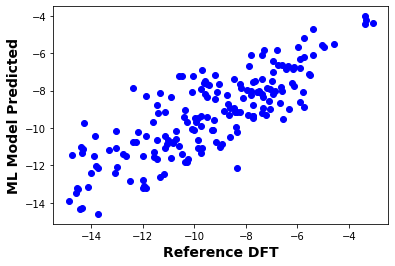

In [12]:
# 1) Initialize our lists
mol_mw, mol_logp, mol_rb, mol_numhd, mol_numha = ([] for i in range(5))

# 2) Generate new data: molecular weight, LogP, number of rotatable bonds, number of hydrogen bond donors, and number of hydrogen bond acceptors 
for mol in data['smiles']:
  mols = Chem.MolFromSmiles(mol) 
  mols_mw = Descriptors.ExactMolWt(mols)
  mols_logp = Descriptors.MolLogP(mols)
  mols_rb = Descriptors.NumRotatableBonds(mols)
  mols_numhd = Chem.Lipinski.NumHDonors(mols)
  mols_numha = Chem.Lipinski.NumHAcceptors(mols)
  
  mol_mw.append(mols_mw)
  mol_logp.append(mols_logp)
  mol_rb.append(mols_rb)
  mol_numhd.append(mols_numhd)
  mol_numha.append(mols_numha)

data['MW'] = mol_mw
data['MolLogP'] = mol_logp
data['NumRotatableBonds'] = mol_rb
data['NumHDonors'] = mol_numhd
data['NumHAcceptors'] = mol_numha

# 3) Build the dataset
X = pd.concat([data['MW'], data['MolLogP'], data['NumRotatableBonds'], data['NumHDonors'], data['NumHAcceptors']], axis = 1)
y = data['cal_solv_free']
dataset = dc.data.NumpyDataset(X = X, y = y)

# 4) Split the dataset into the training, validation, and test sets
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# 5) Normalize dataset
transformer = dc.trans.NormalizationTransformer(transform_y = True, dataset = dataset)
train_dataset = transformer.transform(train_dataset)
valid_dataset = transformer.transform(valid_dataset)
test_dataset = transformer.transform(test_dataset)

# 6) Set the metrics
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)

# 7) Trian the model
sklearn_model = LinearRegression()
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset) 

# 8) Compute and print the scores
train_scores = model.evaluate(train_dataset, [metric])
test_scores = model.evaluate(test_dataset, [metric])
valid_scores = model.evaluate(valid_dataset, [metric])
                              
print(f'Train scores = {train_scores}')
print(f'Test scores = {test_scores}')
print(f'Validation scores = {valid_scores}')

# 9) Prediction
test_preds = model.predict(test_dataset)
test_preds = transformer.untransform(test_preds)
test_dataset = transformer.untransform(test_dataset.y)

plt.scatter(x = test_dataset, y = test_preds, c = 'blue')
plt.xlabel('Reference DFT', fontsize = 14, weight = 'bold')
plt.ylabel('ML Model Predicted', fontsize = 14, weight = 'bold')

plt.show()